In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mstats
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve, 
    roc_auc_score, 
    roc_curve,
)
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.svm import SVC

# Configs

In [2]:
project_root = "D:/Projects/Summer-2024-ECE-597-Group8"
random_state = 42
test_size = 0.1

In [3]:
df = pd.read_csv(
    os.path.join(project_root, "data", "processed", "features_tfidf_labels.csv")
)

# Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28281 entries, 0 to 28280
Columns: 193 entries, Word_Count to Label
dtypes: float64(187), int64(6)
memory usage: 41.6 MB


In [5]:
df.describe()

,Word_Count,Homoglyphs,Total_Abnormal_Count,html_tags,js_code,tfidf_able,tfidf_access,tfidf_account,tfidf_add,tfidf_address,...,tfidf_urladdress,tfidf_use,tfidf_visit,tfidf_want,tfidf_way,tfidf_wednesday,tfidf_week,tfidf_work,tfidf_year,Label
count,28281.000000,28281.000000,28281.000000,28281.000000,28281.000000,28281.000000,28281.000000,28281.000000,28281.000000,28281.000000,...,28281.000000,28281.000000,28281.000000,28281.000000,28281.000000,28281.000000,28281.000000,28281.000000,28281.000000,28281.000000
mean,234.908914,0.031611,1.251724,5.003253,0.000106,0.008010,0.012773,0.017220,0.007351,0.014666,...,0.077181,0.019625,0.008392,0.026043,0.011902,0.013068,0.027898,0.027421,0.021803,0.090909
std,551.882710,1.198740,7.140445,62.911567,0.010299,0.040769,0.064840,0.082621,0.044592,0.063118,...,0.185947,0.064786,0.042772,0.085524,0.054445,0.058547,0.083215,0.080739,0.073917,0.287485
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,98.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,229.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.029114,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,20681.000000,91.000000,371.000000,1977.000000,1.000000,1.000000,1.000000,1.000000,0.977513,0.844442,...,1.000000,1.000000,0.835829,1.000000,1.000000,0.841183,1.000000,1.000000,1.000000,1.000000


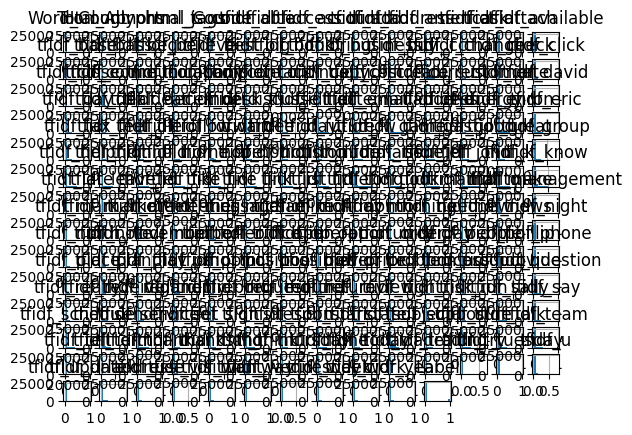

In [6]:
df.hist()
plt.show()

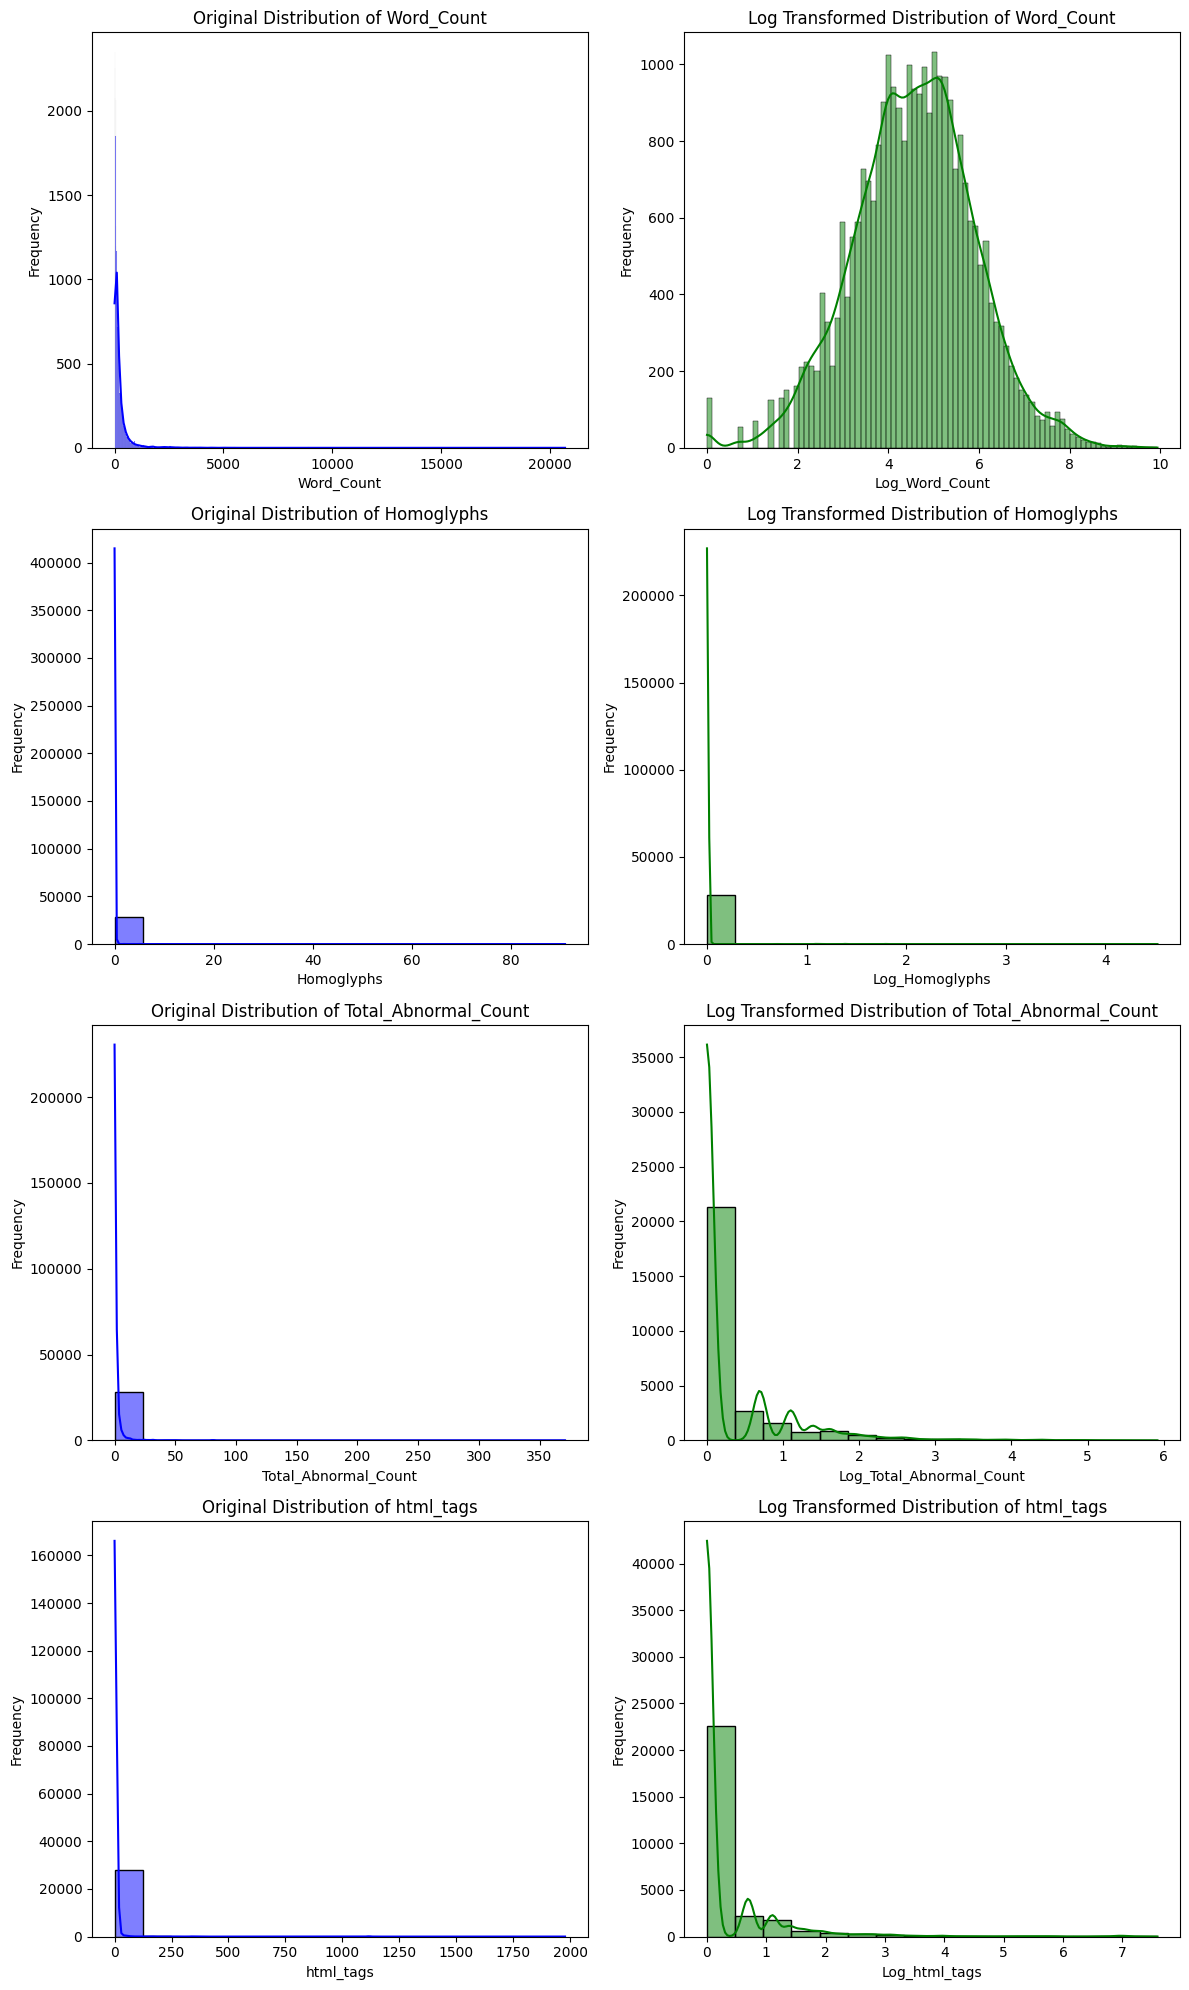

In [7]:
features = ['Word_Count', 'Homoglyphs', 'Total_Abnormal_Count', 'html_tags']

# Setup the plot
fig, axes = plt.subplots(nrows=len(features), ncols=2, figsize=(12, 5 * len(features)))

# Loop through each feature
for i, feature in enumerate(features):
    # Apply log transformation
    log_transformed = np.log1p(df[feature])
    
    # Plot original distribution
    sns.histplot(df[feature], kde=True, ax=axes[i, 0], color='blue')
    axes[i, 0].set_title(f'Original Distribution of {feature}')
    axes[i, 0].set_xlabel(f'{feature}')
    axes[i, 0].set_ylabel('Frequency')
    
    # Plot log transformed distribution
    sns.histplot(log_transformed, kde=True, ax=axes[i, 1], color='green')
    axes[i, 1].set_title(f'Log Transformed Distribution of {feature}')
    axes[i, 1].set_xlabel(f'Log_{feature}')
    axes[i, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

# Experiments

In [8]:
def evaluate_model(model, X, y, cv=3):
    """
    Evaluates the performance of a binary classifier using cross-validation.

    Args:
    model (estimator): The machine learning model to evaluate.
    X (DataFrame or array-like): Feature data used for training the model.
    y (array-like): True labels.
    cv (int): Number of cross-validation folds.

    Returns:
    None
    """
    # Get decision function scores via cross-validation
    y_scores = cross_val_predict(model, X, y, cv=cv, method='decision_function')

    # Convert decision scores to binary predictions using 0 as a threshold
    y_pred = (y_scores > 0).astype(int)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y, y_pred))

    # Print confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))

    # Calculate and print accuracy
    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Calculate ROC-AUC and Precision-Recall
    roc_auc = roc_auc_score(y, y_scores)
    average_precision = average_precision_score(y, y_scores)

    # Print ROC-AUC and Average Precision-Recall scores
    print(f"ROC-AUC Score: {roc_auc:.2f}")
    print(f"Average Precision-Recall Score: {average_precision:.2f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y, y_scores)
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve (area = {average_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()

In [9]:
X = df.drop(columns=["Label"])
y = df["Label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)

In [10]:
def bool_to_int(x):
    return x.astype(int)


def log_transform(x):
    return np.log1p(x)


homoglyphs_pipeline = make_pipeline(FunctionTransformer(log_transform))
homoglyphs_pipeline_MinMax = make_pipeline(
    FunctionTransformer(log_transform), MinMaxScaler()
)
homoglyphs_pipeline_standardScaler = make_pipeline(
    FunctionTransformer(log_transform), StandardScaler()
)
log_transform_pipeline_RobustScaler = make_pipeline(
    FunctionTransformer(log_transform), RobustScaler()
)

features_preprocessor = ColumnTransformer(
    transformers=[
        (
            "log_transform",
            log_transform_pipeline_RobustScaler,
            [
                "Word_Count",
                "Homoglyphs",
                "Total_Abnormal_Count",
                "html_tags",
                "js_code",
            ],
        ),
    ],
    remainder="passthrough",
)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     23122
           1       0.94      0.77      0.84      2330

    accuracy                           0.97     25452
   macro avg       0.96      0.88      0.91     25452
weighted avg       0.97      0.97      0.97     25452

Confusion Matrix:
[[23002   120]
 [  543  1787]]
Accuracy: 0.97
ROC-AUC Score: 0.99
Average Precision-Recall Score: 0.93


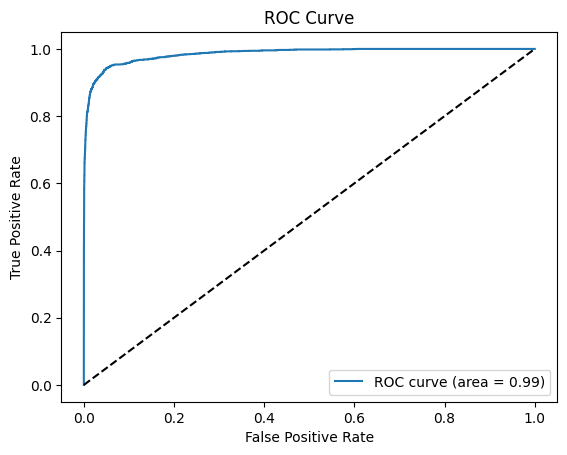

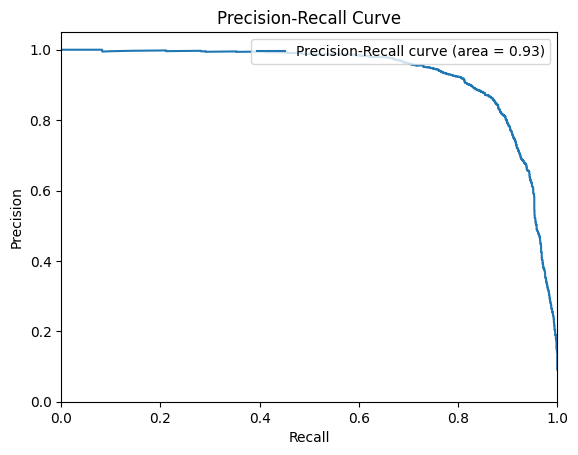

In [11]:
model = make_pipeline(
    features_preprocessor,
    # PCA(n_components=0.95),
    SVC(
        C=1.0, kernel="rbf", gamma="scale", random_state=random_state
    ),
)

model.fit(X_train, y_train)
evaluate_model(model, X_train, y_train)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     25710
           1       0.80      0.60      0.68      2571

    accuracy                           0.95     28281
   macro avg       0.88      0.79      0.83     28281
weighted avg       0.95      0.95      0.95     28281

Confusion Matrix:
[[25315   395]
 [ 1026  1545]]
Accuracy: 0.95
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.67


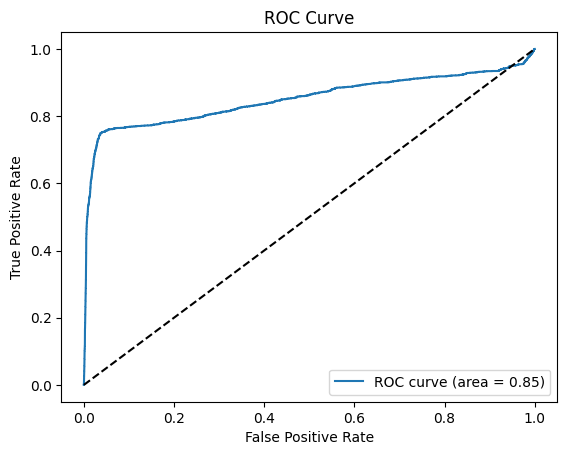

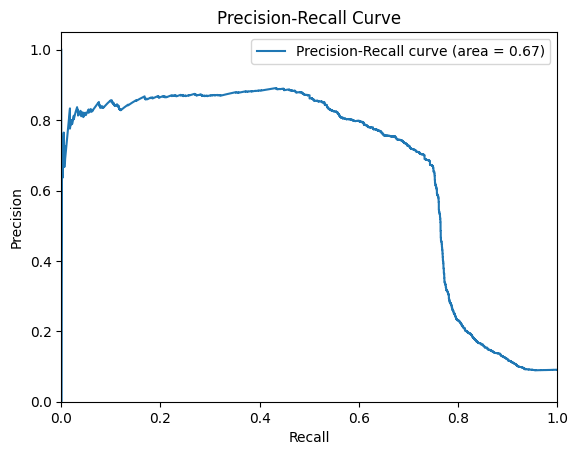

In [12]:
# try again with FLD
model = make_pipeline(
    features_preprocessor,
    LDA(),
    SVC(
        C=1.0, kernel="rbf", gamma="scale", random_state=random_state
    ),
)

model.fit(X_train, y_train)
evaluate_model(model, X, y)